In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.4 MB/s eta 0:00:00


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Bidirectional, Dropout, Activation, Reshape, Permute, Dot, Lambda, Softmax
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import optuna
import pickle
import tensorflow as tf
from timeit import default_timer as timer
plt.style.use('fivethirtyeight')

In [3]:
def fetch_data(crypto, against, start_year):
  start = dt.datetime(start_year, 1, 1)
  end = dt.datetime(dt.date.today().year, dt.date.today().month, dt.date.today().day - 1)
  ticker = f'{crypto}-{against}'

  print(f'Fetching {ticker} data from {start.year} to {end.year}...')
  try:
    df = yf.download(tickers = ticker, start = start, end = end, progress = False)

    if df.empty:
      raise ValueError(f'No data found for {ticker}.')

    print(f"Success: {len(df)} records retrieved")
    return df
  except Exception as e:
    print(f"Error: {e}")
    return None

In [49]:
currency = input('Enter currency pair (e.g., BTC-USD): ').upper()
crypto, against = currency.split('-')
start_year = int(input('Enter start year (e.g., 2018): '))

df = fetch_data(crypto, against, start_year)
if df is None:
    raise SystemExit("Data fetch failed. Exiting...")

Enter currency pair (e.g., BTC-USD): eth-usd
Enter start year (e.g., 2018): 2019
Fetching ETH-USD data from 2019 to 2025...
YF.download() has changed argument auto_adjust default to True
Success: 2266 records retrieved


In [52]:
df.columns = [col[0] for col in df.columns]
df.reset_index(inplace=True)

print(df.shape)
df.head()

(2266, 6)


,Date,Close,High,Low,Open,Volume
0,2019-01-01,140.819412,141.397507,132.650711,133.418152,2258709868
1,2019-01-02,155.047684,156.929138,140.650955,141.519516,3328240369
2,2019-01-03,149.135010,155.863052,147.198364,155.196045,2676164880
3,2019-01-04,154.581940,156.878983,147.907104,148.912888,3126192535
4,2019-01-05,155.638596,160.824890,154.337418,154.337418,3338211928


In [4]:
df = pd.read_csv('Training_df.csv')
crypto, against = 'ETH', 'USD'
df.shape

(2260, 6)

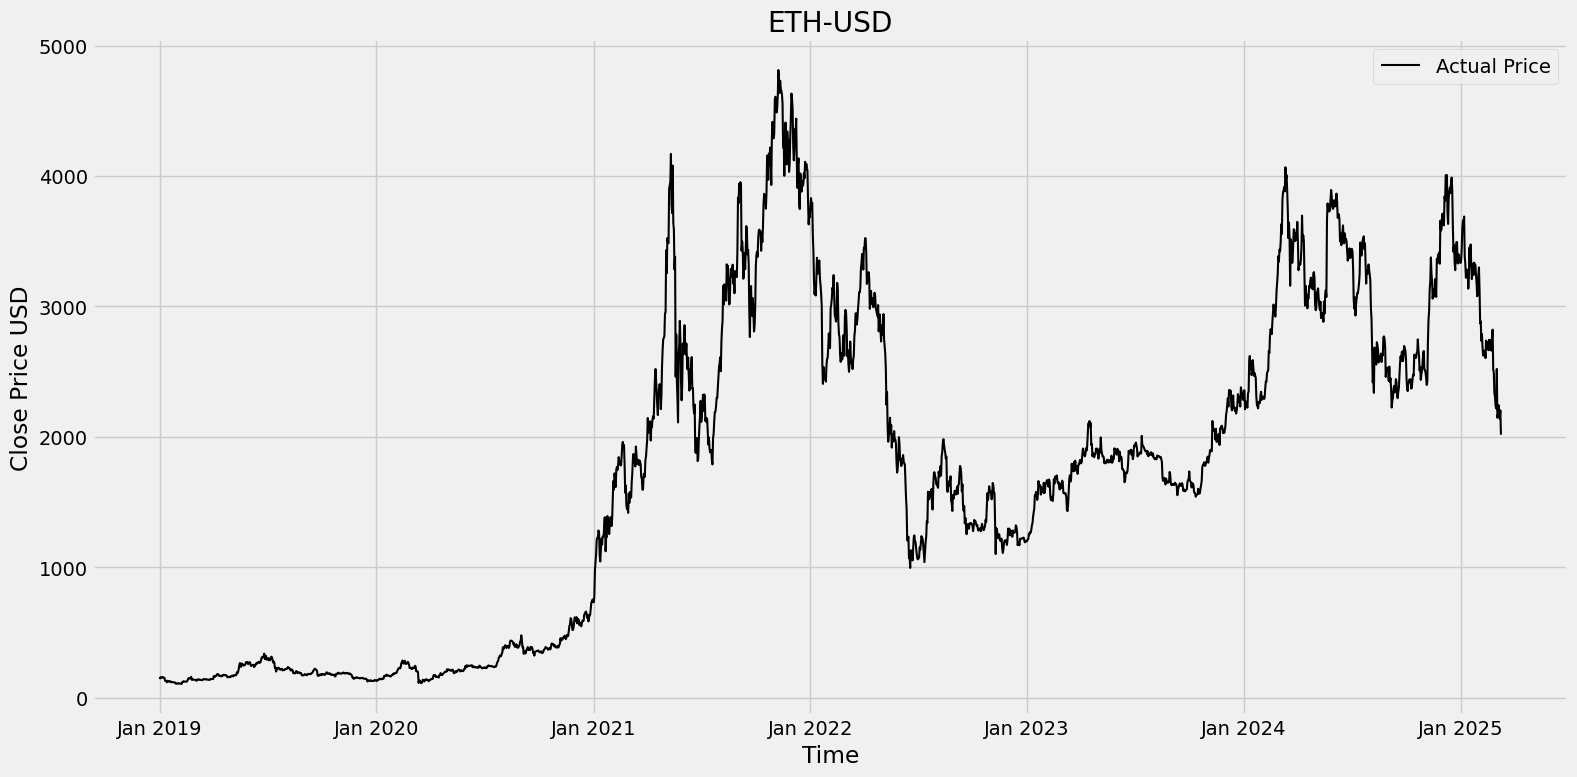

In [5]:
def plot_predictions(y_true, dates, y_pred_mean=None, confidence_interval=None):
  plt.figure(figsize=(16, 8))

  plt.plot(dates, y_true, label='Actual Price', color='black', linewidth=1.5)

  if y_pred_mean is not None and confidence_interval is not None:
      plt.plot(dates, y_pred_mean, label='Predicted Price', color='blue', linewidth=1.5)
      plt.fill_between(dates, y_pred_mean - confidence_interval, y_pred_mean + confidence_interval, color='blue', alpha=0.2, label='95% Confidence Interval')

  plt.title(f"{crypto}-{against}")
  plt.xlabel("Time")
  plt.ylabel(f"Close Price {against}")
  plt.legend()

  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

  plt.tight_layout()
  plt.show()

dates = pd.to_datetime(df['Date'])
plot_predictions(df['Close'], dates)

In [6]:
def add_indicators(df):
  df = df.copy()
  print('Engineering features...')

  df['MA_10'] = df['Close'].rolling(window=10).mean()
  df['MA_50'] = df['Close'].rolling(window=50).mean()
  df['MA_200'] = df['Close'].rolling(window=200).mean()

  delta = df['Close'].diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
  rs = gain / loss
  df['RSI'] = 100 - (100 / (1 + rs))

  ema12 = df['Close'].ewm(span=12, adjust=False).mean()
  ema26 = df['Close'].ewm(span=26, adjust=False).mean()
  df['MACD'] = ema12 - ema26
  df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

  df['Volatility'] = df['Close'].rolling(window=20).std()
  df['BB_Upper'] = df['MA_50'] + (df['Volatility'] * 2)
  df['BB_Lower'] = df['MA_50'] - (df['Volatility'] * 2)

  df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum().fillna(0)

  df.dropna(inplace=True)
  print(f"Features engineered. Shape: {df.shape}")
  return df

df_update = add_indicators(df)

Engineering features...
Features engineered. Shape: (2061, 16)


In [7]:
df_update.head()

,Date,Close,High,Low,Open,Volume,MA_10,MA_50,MA_200,RSI,MACD,Signal_Line,Volatility,BB_Upper,BB_Lower,OBV
199,2019-07-19,221.333420,226.940475,215.838242,226.657700,7606433131,242.036916,272.149401,184.629854,32.672842,-17.670029,-8.896943,35.977408,344.104217,200.194585,1.233018e+11
200,2019-07-20,229.119217,234.198456,221.189484,221.412659,7976245988,235.948605,271.369514,185.071353,35.371392,-17.579176,-10.633390,36.683750,344.737014,198.002014,1.312780e+11
201,2019-07-21,225.630768,229.861664,219.027756,229.167694,6685082868,231.641278,270.574304,185.424268,28.364105,-17.585943,-12.023900,37.163631,344.901566,196.247042,1.245929e+11
202,2019-07-22,217.560013,226.862579,213.448380,225.698654,6338843919,225.769609,269.520994,185.766393,24.215395,-18.034656,-13.226051,37.834566,345.190126,193.851862,1.182541e+11
203,2019-07-23,212.728516,218.518051,209.638123,217.568466,6976091534,220.096581,268.723406,186.057126,24.155370,-18.566107,-14.294062,37.709961,344.143328,193.303483,1.112780e+11


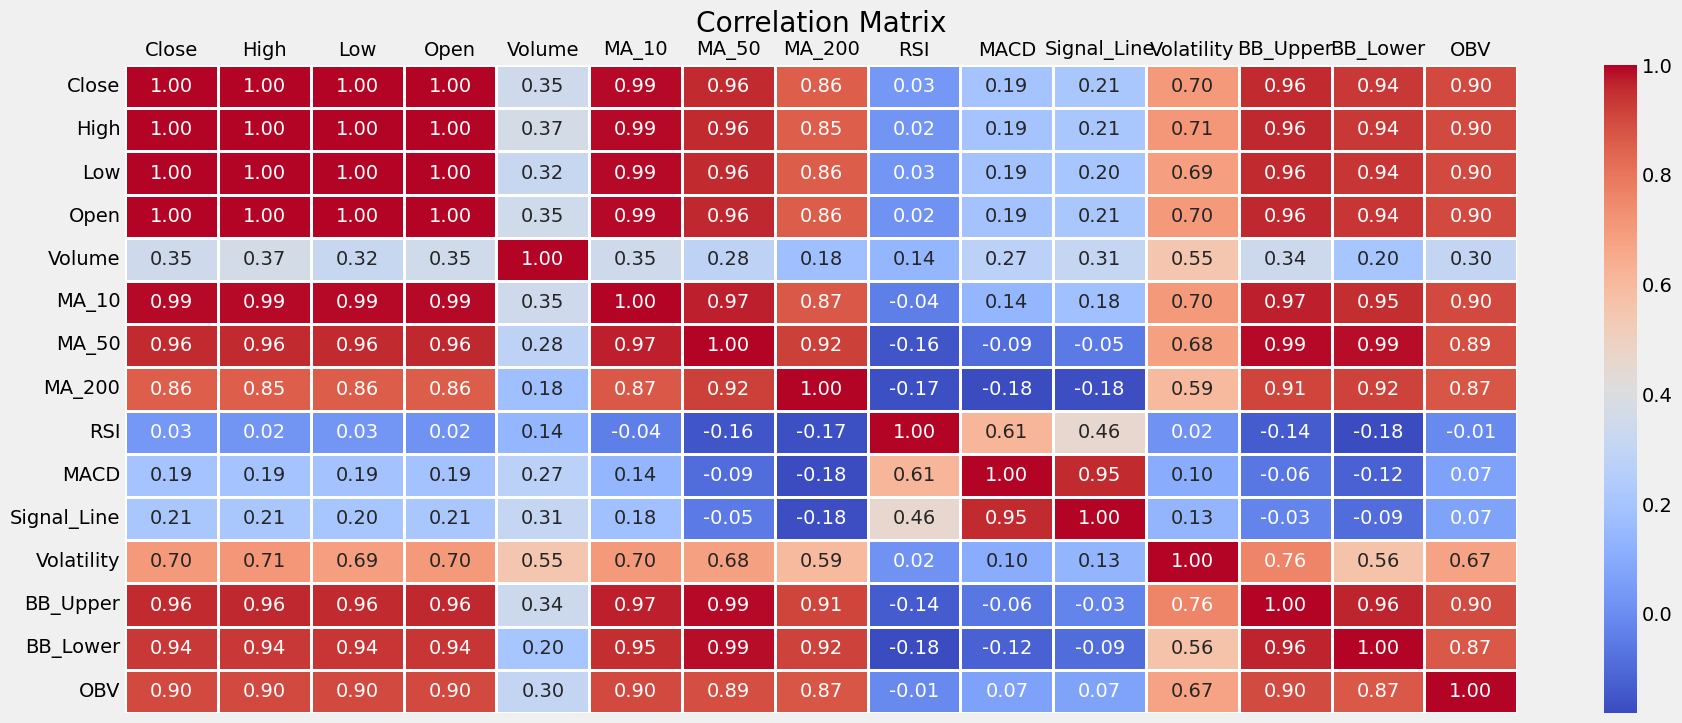

Most Co-releated Features:
High           0.998637
Low            0.998510
Open           0.997170
MA_10          0.992357
BB_Upper       0.957940
MA_50          0.956512
BB_Lower       0.935031
OBV            0.899841
MA_200         0.855045
Volatility     0.703003
Volume         0.347772
Signal_Line    0.208216
MACD           0.194664
RSI            0.034164
Name: Close, dtype: float64


In [8]:
corr_mat = df_update.drop('Date', axis = 1).corr()

plt.figure(figsize = (20, 8))
sns.heatmap(corr_mat, annot = True, linewidths = 1, linecolor = 'white', cmap = 'coolwarm', fmt = '.2f')
plt.gca().xaxis.set_ticks_position('top')

plt.title('Correlation Matrix')
plt.show()

print("Most Co-releated Features:")
print(corr_mat['Close'].sort_values(ascending = False).drop('Close'))

In [9]:
def data_preparation(df, target_col = 'Close', window_size = 60):
  X, y = [], []
  data = df.drop('Date', axis = 1).values

  for i in range(window_size, len(df)):
    X.append(data[i - window_size: i])
    y.append(data[i, df.columns.get_loc(target_col)])

  X, y = np.array(X), np.array(y)

  train_size = int(0.7 * len(X))
  val_size = int(0.15 * len(X))

  X_train = X[:train_size]
  y_train = y[:train_size]

  X_val = X[train_size: train_size + val_size]
  y_val = y[train_size: train_size + val_size]

  X_test = X[train_size + val_size:]
  y_test = y[train_size + val_size:]

  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = data_preparation(df_update)
print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
print(f"Shapes: y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}")

Shapes: X_train=(1400, 60, 15), X_val=(300, 60, 15), X_test=(301, 60, 15)
Shapes: y_train=(1400,), y_val=(300,), y_test=(301,)


In [10]:
n_samples_train, n_timesteps, n_features = X_train.shape
X_train_2d = X_train.reshape(-1, n_features)

scaler = MinMaxScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(n_samples_train, n_timesteps, n_features)

X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], n_timesteps, n_features)

close_idx = df_update.columns.get_loc('Close')
y_train_scaled = (y_train - scaler.data_min_[close_idx]) / (scaler.data_max_[close_idx] - scaler.data_min_[close_idx])
y_val_scaled = (y_val - scaler.data_min_[close_idx]) / (scaler.data_max_[close_idx] - scaler.data_min_[close_idx])
y_test_scaled = (y_test - scaler.data_min_[close_idx]) / (scaler.data_max_[close_idx] - scaler.data_min_[close_idx])

In [11]:
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_val_scaled.shape, y_val_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

(1400, 60, 15) (1400,)
(300, 60, 15) (300,)
(301, 60, 15) (301,)


In [12]:
def attention_mechanism(lstm_out):
  attention = Dense(1, activation='tanh')(lstm_out)
  attention = Softmax(axis=1)(attention)
  output = Dot(axes=1)([attention, lstm_out])
  return output

In [13]:
def build_model(params, input_shape):
  inputs = Input(shape=input_shape)

  x = Conv1D(filters=params['conv_filters'], kernel_size=params['kernel_size'], activation='relu', padding='same')(inputs)
  x = Bidirectional(LSTM(units=params['lstm_units_1'], return_sequences=True, recurrent_dropout=params['rec_dropout'], kernel_regularizer=L2(params['l2_strength'])))(x)

  x = attention_mechanism(x)

  x = Bidirectional(LSTM(units=params['lstm_units_2'], recurrent_dropout=params['rec_dropout'], kernel_regularizer=L2(params['l2_strength'])))(x)
  x = Dropout(params['dropout'])(x)
  outputs = Dense(1)(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=AdamW(learning_rate=params['learning_rate']), loss='mse')
  return model

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

In [14]:
def objective(trial):
  params = {
      'conv_filters': trial.suggest_int('conv_filters', 32, 128, step=16),
      'kernel_size': trial.suggest_int('kernel_size', 2, 5),
      'lstm_units_1': trial.suggest_int('lstm_units_1', 50, 200, step=25),
      'lstm_units_2': trial.suggest_int('lstm_units_2', 25, 100, step=25),
      'rec_dropout': trial.suggest_float('rec_dropout', 0.1, 0.4, step=0.1),
      'dropout': trial.suggest_float('dropout', 0.2, 0.5, step=0.1),
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
      'l2_strength': trial.suggest_float('l2_strength', 0.001, 0.1, log=True)
  }

  model = build_model(params, input_shape)
  history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                      epochs=50, batch_size=32,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)],
                      verbose=0)
  return min(history.history['val_loss'])

In [ ]:
print("Starting hyperparameter tuning with 20 trials...")
start_time = timer()
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)
tuning_time = timer() - start_time

print(f"Hyperparameter tuning completed in {tuning_time / 60:.2f} minutes. \nBest params:", study.best_params)
best_params = study.best_params

In [15]:
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

print("Loaded Best Parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Loaded Best Parameters:
conv_filters: 32
kernel_size: 4
lstm_units_1: 175
lstm_units_2: 75
rec_dropout: 0.1
dropout: 0.30000000000000004
learning_rate: 0.004238734119548234
l2_strength: 0.0010744261145475028


In [37]:
best_params

{'conv_filters': 32,
 'kernel_size': 4,
 'lstm_units_1': 175,
 'lstm_units_2': 75,
 'rec_dropout': 0.1,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.004238734119548234,
 'l2_strength': 0.0010744261145475028}

In [17]:
def get_callbacks(patience = 15):
  return [
      EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True, mode = 'min'),
      ReduceLROnPlateau(monitor= 'val_loss', factor = 0.5, patience = 5, min_lr = 0.00001, mode = 'min'),
      ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only = True, mode = 'min')
  ]

In [ ]:
print('Training final neural network model...')
nn_model = build_model(best_params, input_shape)
nn_model.summary()

Training final neural network model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 60, 15)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 60, 96)         │          5,856 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 60, 100)        │         58,800 │ conv1d_5[0][0]         │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 60, 1)          │            101 │ bidirectional_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_5 (Softmax)       │ (None, 60, 1)          │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_5 (Dot)               │ (None, 1, 100)         │              0 │ softmax_5[0][0],       │
│                           │                        │                │ bidirectional_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_11          │ (None, 50)             │         25,200 │ dot_5[0][0]            │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 50)             │              0 │ bidirectional_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             51 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 90,008 (351.59 KB)

 Trainable params: 90,008 (351.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = nn_model.fit(X_train_scaled, y_train_scaled, validation_data = (X_val_scaled, y_val_scaled),
                       epochs = 100, batch_size = 64, callbacks = get_callbacks(), verbose = 1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - loss: 0.3664 - val_loss: 0.0866 - learning_rate: 0.0099
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 0.0790 - val_loss: 0.0325 - learning_rate: 0.0099
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0322 - val_loss: 0.0152 - learning_rate: 0.0099
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.0177 - val_loss: 0.0089 - learning_rate: 0.0099
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.0118 - val_loss: 0.0061 - learning_rate: 0.0099
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.0103 - val_loss: 0.0051 - learning_rate: 0.0099
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.0085 - val_loss: 0.0065 - learning_rate: 0.0099
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0081 - val_loss: 0.0040 - learning_rate: 0.0099
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.0089 - val_loss: 0.0034 - learning_rate: 0.0099


In [18]:
nn_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
history = history.history
history.keys()

In [19]:
history = pd.read_csv('best_training_history.csv')
history = history.to_dict(orient='list')
history.keys()

dict_keys(['loss', 'val_loss', 'learning_rate'])

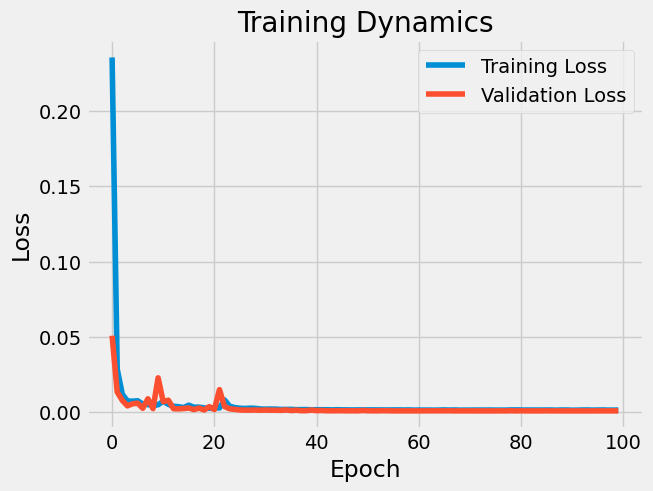

In [20]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training Dynamics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def mc_dropout_predict(model, X, n_samples = 100):
  @tf.function
  def model_predict(x):
    return model(x, training=True)

  predictions = np.array([model_predict(tf.convert_to_tensor(X, dtype = tf.float32)).numpy() for _ in range(n_samples)])
  return predictions.mean(axis=0), predictions.std(axis=0)

y_pred_mean_scaled, y_pred_std_scaled = mc_dropout_predict(nn_model, X_test_scaled)

In [22]:
y_pred_mean = y_pred_mean_scaled * (scaler.data_max_[close_idx] - scaler.data_min_[close_idx]) + scaler.data_min_[close_idx]
y_pred_std = y_pred_std_scaled * (scaler.data_max_[close_idx] - scaler.data_min_[close_idx])

confidence_interval = 1.96 * y_pred_std

In [23]:
y_pred_mean = y_pred_mean.flatten()
y_pred_std = y_pred_std.flatten()
confidence_interval = confidence_interval.flatten()

In [25]:
data = np.load('predictions_best_yet.npz')
y_pred_mean = data['y_pred_mean']
y_pred_std = data['y_pred_std']
confidence_interval = data['confidence_interval']
confidence_interval = confidence_interval.flatten()

Monte Carlo Dropout Model Evaluation Metrics:
Mean Squared Error (MSE): 18242.13
Root Mean Squared Error (RMSE): 135.06
Mean Absolute Error (MAE): 102.22
R² Score: 0.9278
Directional Accuracy: 60.33%


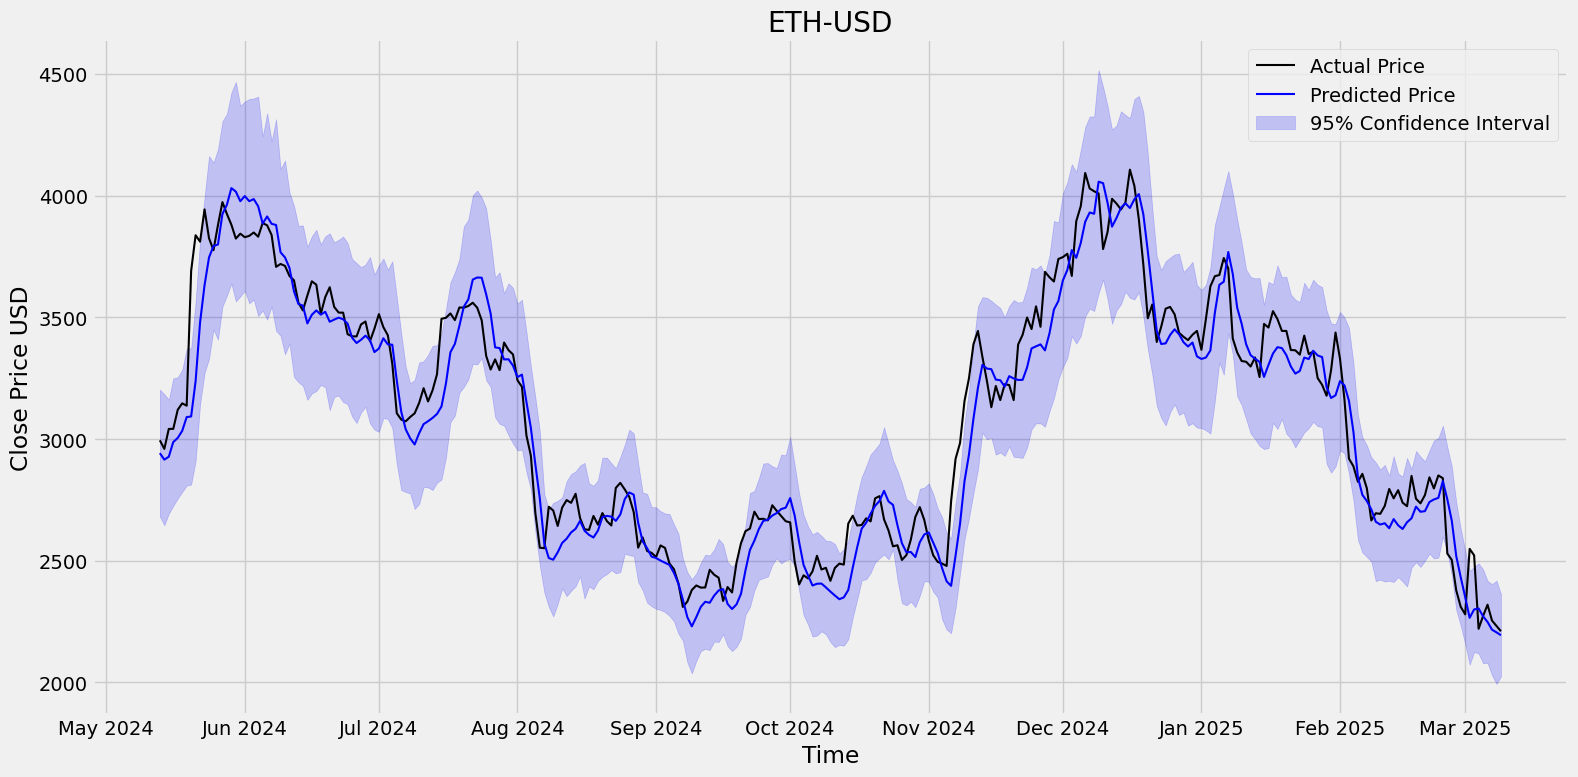

In [26]:
def eval_model(y_true, y_pred, name):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  y_true_diff = np.diff(y_true)
  y_pred_diff = np.diff(y_pred)
  directional_accuracy = np.mean(np.sign(y_true_diff) == np.sign(y_pred_diff)) * 100

  print(f"{name} Model Evaluation Metrics:")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"R² Score: {r2:.4f}")
  print(f"Directional Accuracy: {directional_accuracy:.2f}%")

  return mse, rmse, mae, r2, directional_accuracy

mc_mse, mc_rmse, mc_mae, mc_r2, mc_directional_accuracy = eval_model(y_test, y_pred_mean, "Monte Carlo Dropout")

test_dates = pd.to_datetime(df_update['Date'].iloc[-len(y_test):])
plot_predictions(y_test, test_dates, y_pred_mean, confidence_interval)

In [36]:
def predict_future(model, df, scaler, window_size, n_days, n_samples=100):
    df = df.sort_values('Date').reset_index(drop=True)

    last_window = df.iloc[-window_size:].drop('Date', axis=1).values
    last_date = pd.to_datetime(df['Date'].iloc[-1])

    future_dates = []
    future_predictions = []
    future_confidence_intervals = []

    current_window = last_window.copy()
    close_idx = df.columns.get_loc('Close')

    for i in range(n_days):
        current_window_2d = current_window.reshape(-1, current_window.shape[-1])
        current_window_scaled = scaler.transform(current_window_2d).reshape(1, window_size, current_window.shape[-1])

        predictions_scaled = np.array([model(current_window_scaled, training=True).numpy() for _ in range(n_samples)])
        pred_mean_scaled = predictions_scaled.mean(axis=0)
        pred_std_scaled = predictions_scaled.std(axis=0)

        pred_mean = pred_mean_scaled * (scaler.data_max_[close_idx] - scaler.data_min_[close_idx]) + scaler.data_min_[close_idx]
        pred_std = pred_std_scaled * (scaler.data_max_[close_idx] - scaler.data_min_[close_idx])
        confidence_interval = 1.96 * pred_std

        future_date = last_date + timedelta(days=i + 1)
        future_dates.append(future_date)
        future_predictions.append(pred_mean.flatten()[0])
        future_confidence_intervals.append(confidence_interval.flatten()[0])

        new_row = current_window[-1].copy()
        new_row[df.columns.get_loc('Close')] = pred_mean.flatten()[0]

        current_window = np.vstack((current_window[1:], new_row))

    return future_dates, future_predictions, future_confidence_intervals

n_days = 4
future_dates, future_predictions, future_confidence_intervals = predict_future(
    nn_model, df_update, scaler, window_size=60, n_days=n_days
)

In [47]:
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Confidence_Interval': future_confidence_intervals
})

future_df.to_csv('future_predictions.csv', index=False)

In [48]:
future_df

,Date,Predicted_Close,Confidence_Interval
0,2025-03-10,2165.110596,186.280441
1,2025-03-11,2113.489258,165.918076
2,2025-03-12,2084.651367,193.231094
3,2025-03-13,2057.144287,175.386581


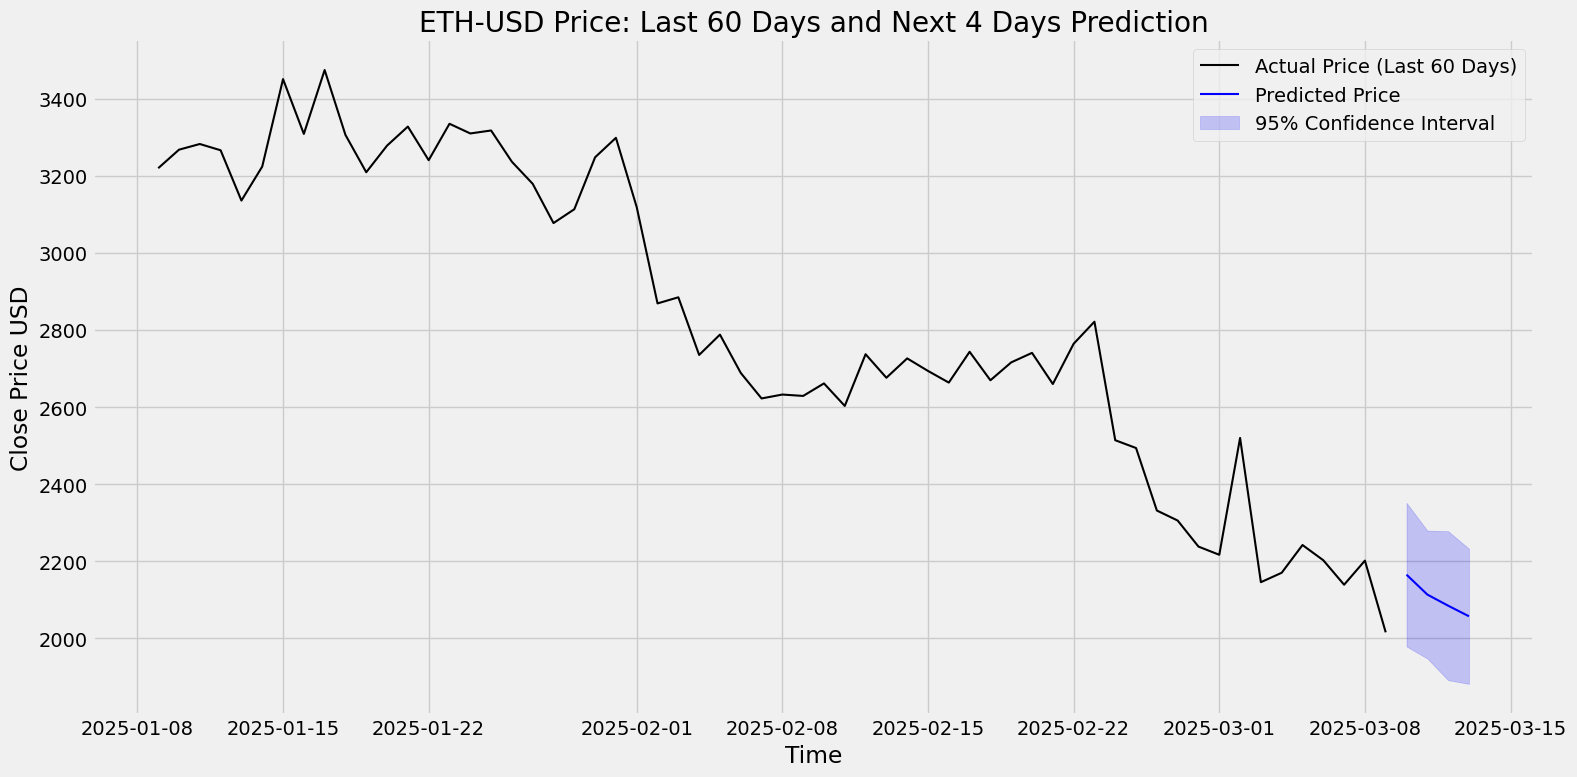

In [44]:
def plot_future_predictions(last_window_dates, last_window_prices, future_dates, future_predictions, future_confidence_intervals):
    plt.figure(figsize=(16, 8))
    plt.plot(last_window_dates, last_window_prices, label='Actual Price (Last 60 Days)', color='black', linewidth=1.5)

    all_dates = list(last_window_dates) + future_dates
    all_predictions = list(last_window_prices) + future_predictions
    plt.plot(all_dates[-4:], all_predictions[-4:], label='Predicted Price', color='blue', linewidth=1.5)

    future_dates_array = np.array(future_dates)
    future_predictions_array = np.array(future_predictions)
    future_confidence_intervals_array = np.array(future_confidence_intervals)
    plt.fill_between(
        future_dates,
        future_predictions_array - future_confidence_intervals_array,
        future_predictions_array + future_confidence_intervals_array,
        color='blue', alpha=0.2, label='95% Confidence Interval'
    )

    plt.title(f"{crypto}-{against} Price: Last 60 Days and Next 4 Days Prediction")
    plt.xlabel("Time")
    plt.ylabel(f"Close Price {against}")
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.tight_layout()
    plt.show()

window_size = 60
last_window_df = df_update.tail(window_size)
last_window_dates = pd.to_datetime(last_window_df['Date'])
last_window_prices = last_window_df['Close']

plot_future_predictions(last_window_dates, last_window_prices, future_dates, future_predictions, future_confidence_intervals)

In [ ]:
nn_model.save('best_yet.keras')

In [ ]:
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [ ]:
history_df = pd.DataFrame(history)
history_df.to_csv('best_training_history.csv', index=False)

In [ ]:
df.to_csv('Training_df.csv', index = False)

In [ ]:
np.savez('predictions_best_yet.npz',
         y_pred_mean=y_pred_mean,
         y_pred_std=y_pred_std,
         confidence_interval=confidence_interval)